In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

In [3]:
%%time
train_transaction = pd.read_csv('newtrain_transaction_200000.csv', index_col='TransactionID')
test_transaction = pd.read_csv('newtest_transaction_withoutlabel.csv', index_col='TransactionID')
train_identity = pd.read_csv('newtrain_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('newtest_identity.csv', index_col='TransactionID')
sample_submission = pd.read_csv('newsample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
# del train_transaction, train_identity, test_transaction, test_identity


# Drop target
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

# del train, test

(80397, 433)
(10000, 432)
Wall time: 3.29 s


### Distribution Visualization

In [9]:
train.columns.tolist()

['isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67

In [67]:
#Plotting Seaborn Distribution Plot Function
def sns_distplot(df,x,xlabel,hue,ylabel=None,element=None,title=None,color='steelblue',font=2.2,style='ticks',size=[18,9]):
    #seaborn style and font size setting
    sns.set(font_scale = font) 
    sns.set_style(style) 
    plot = sns.displot(df, x=x,kind='kde',color=color,hue=hue)
    plot.set(xlabel=xlabel,ylabel=ylabel,title=title)
    plot.figure.set_size_inches(size[0],size[1])

#Plotting Seaborn Category Plot Function
def sns_catplot(df,x,y,kind,hue=None,hue_order=None,xlabel=None,ylabel=None,title=None,color=None,palette=None,font=2,style='ticks',size=[10,10]):
    sns.set(font_scale = font)
    sns.set_style(style)
    plot = sns.catplot(data=df, x=x,y=y,hue=hue,hue_order=hue_order,kind=kind,color=color,palette=palette,legend_out=False)
    plot.set(xlabel=xlabel,ylabel=ylabel,title=title)
    plot.figure.set_size_inches(size[0],size[1])  

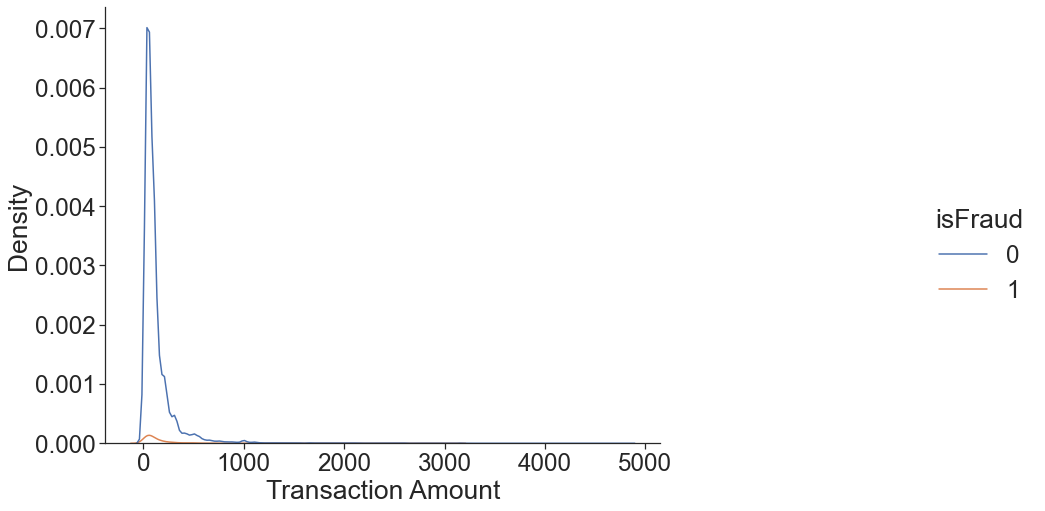

In [68]:
sns_distplot(train,x='TransactionAmt',xlabel="Transaction Amount",ylabel="Density",hue="isFraud")

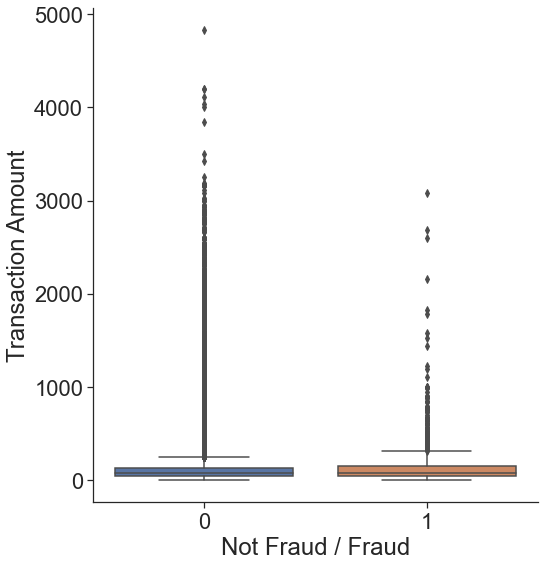

In [64]:
sns_catplot(train,x='isFraud',y='TransactionAmt',kind="box",xlabel="Not Fraud / Fraud",ylabel='Transaction Amount')

### Check missing ratio

In [24]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

### Drop the features with high missingratio (> 50%) 

In [25]:
missing_values = missing_values_table(X_train)
print(missing_values.head(232))

# drop the absence 
drop_list=missing_values.index
print(drop_list[0:232])

Your selected dataframe has 432 columns.
There are 369 columns that have missing values.
       Missing Values  % of Total Values
id_24           79348               98.7
id_25           79275               98.6
id_21           79268               98.6
id_07           79266               98.6
id_08           79266               98.6
...               ...                ...
id_01           50672               63.0
id_12           50672               63.0
M4              45255               56.3
D2              44303               55.1
D3              43087               53.6

[232 rows x 2 columns]
Index(['id_24', 'id_25', 'id_21', 'id_07', 'id_08', 'id_26', 'id_27', 'id_22',
       'id_23', 'D7',
       ...
       'id_15', 'id_29', 'id_38', 'id_11', 'D5', 'id_01', 'id_12', 'M4', 'D2',
       'D3'],
      dtype='object', length=232)


In [26]:
X_train=X_train.drop(columns=drop_list[0:232])
X_test=X_test.drop(columns=drop_list[0:232])

X_test_filter = X_test.copy()
X_train_filter = X_train.copy()

### drop all the NaN columns
### dropna() - 
for column in X_test_filter.columns:
        if pd.isnull(X_test_filter[column].unique()[0]):
            X_train_filter.drop([column], axis = 1, inplace=True)
            X_test_filter.drop([column], axis = 1, inplace=True)

print(X_train_filter.shape)

(80397, 432)
(80397, 200)
(80397, 113)


### Filling null values: fill with the value which is of the highest appearing frequency

In [8]:
def fill_na_df(X_train, X_test):
    for col_name in X_train.columns: 
        X_train[col_name].fillna(X_train[col_name].mode()[0], inplace=True)
        X_test[col_name].fillna(X_test[col_name].mode()[0], inplace=True)

In [21]:
X_train_filter_fill = X_train_filter_.copy()
X_test_filter_fill = X_test_filter_.copy()
fill_na_df(X_train_filter_fill, X_test_filter_fill)
print(X_train_filter_fill)

               TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  \
TransactionID                                                                  
2987000                86400          68.500          4  13926  321.0  150.0   
2987001                86401          29.000          4   2755  404.0  150.0   
2987002                86469          59.000          4   4663  490.0  150.0   
2987003                86499          50.000          4  18132  567.0  150.0   
2987004                86506          50.000          1   4497  514.0  150.0   
...                      ...             ...        ...    ...    ...    ...   
3069537              1781665          30.950          4  15385  111.0  150.0   
3069538              1781683          15.000          4  16661  490.0  150.0   
3069539              1781685          32.356          0   9633  130.0  185.0   
3069540              1781696         335.000          4   2392  360.0  150.0   
3069541              1781720         250

### Label encoding 

In [27]:
# Label Encoding
def label_encoding(X_train, X_test):
    for f in X_train.columns:
        if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[f].values) + list(X_test[f].values))
            X_train[f] = lbl.transform(list(X_train[f].values))
            X_test[f] = lbl.transform(list(X_test[f].values))
    return X_train, X_test

In [29]:
X_train_filter_, X_test_filter_ = label_encoding(X_train_filter, X_test_filter)
print(X_train_filter_.shape)
print(X_test_filter_.shape)

(80397, 113)
(10000, 113)


In [30]:
print(X_train_filter_)

               TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  \
TransactionID                                                                  
2987000                86400          68.500          4  13926    NaN  150.0   
2987001                86401          29.000          4   2755  404.0  150.0   
2987002                86469          59.000          4   4663  490.0  150.0   
2987003                86499          50.000          4  18132  567.0  150.0   
2987004                86506          50.000          1   4497  514.0  150.0   
...                      ...             ...        ...    ...    ...    ...   
3069537              1781665          30.950          4  15385  111.0  150.0   
3069538              1781683          15.000          4  16661  490.0  150.0   
3069539              1781685          32.356          0   9633  130.0  185.0   
3069540              1781696         335.000          4   2392  360.0  150.0   
3069541              1781720         250

### Reduce memory usage

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [11]:
%%time
X_train_filter_fill = reduce_mem_usage(pd.DataFrame(X_train_filter_fill))
X_test_filter_fill = reduce_mem_usage(pd.DataFrame(X_test_filter_fill))

Memory usage of dataframe is 68.70 MB
Memory usage after optimization is: 18.86 MB
Decreased by 72.5%
Memory usage of dataframe is 8.54 MB
Memory usage after optimization is: 2.30 MB
Decreased by 73.1%
Wall time: 5.07 s


### Split training data and testing data

In [12]:
x1=X_train_filter_fill.columns
x2=X_test_filter_fill.columns

sc = StandardScaler()
X_train_filter_fill = sc.fit_transform(X_train_filter_fill)
X_test_filter_fill = sc.fit_transform(X_test_filter_fill)


X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_filter_fill, train['isFraud'], test_size=0.1, random_state=1)
X_train = np.array(X_train2)
y_train = np.array(Y_train2)
X_test = np.array(X_test2)
y_test = np.array(Y_test2)


X_train = pd.DataFrame(data=X_train, columns=x1)
X_test = pd.DataFrame(data=X_test, columns=x2)

In [20]:
print(X_test)

      TransactionDT  TransactionAmt  ProductCD     card1     card2     card3  \
0          0.817831       -0.062733   0.736075 -1.540449  0.279205 -0.275574   
1          1.339465       -0.512884   0.736075  0.225519 -0.049370 -0.275574   
2          1.359837        0.574182  -0.595463  0.152556  0.197062 -0.275574   
3         -0.575129        0.574182  -0.595463  1.377901 -1.249935 -0.275574   
4         -0.971320        0.334740  -0.595463 -0.919749 -0.112558 -0.275574   
...             ...             ...        ...       ...       ...       ...   
8035       1.621646       -0.144144  -0.595463  0.663302 -1.249935 -0.275574   
8036       0.416340       -0.326419   0.736075 -1.667476 -1.224660 -0.275574   
8037       0.252218       -0.223159   0.736075 -1.157135  0.494043 -0.275574   
8038       1.365342       -0.106132   0.736075 -0.035443  1.182788 -0.275574   
8039       0.813651       -0.546631   0.736075  0.147474  1.182788 -0.275574   

         card4     card5     card6     

### Feature detection and analysis:  Pearson coefficient and VIF

                TransactionDT  TransactionAmt  ProductCD     card1     card2  \
TransactionDT        1.000000        0.004347  -0.156036 -0.001232  0.044008   
TransactionAmt       0.004347        1.000000   0.158789 -0.008198  0.008922   
ProductCD           -0.156036        0.158789   1.000000  0.007465 -0.110306   
card1               -0.001232       -0.008198   0.007465  1.000000 -0.008139   
card2                0.044008        0.008922  -0.110306 -0.008139  1.000000   
...                       ...             ...        ...       ...       ...   
V317                -0.004772        0.033879  -0.009975  0.017549 -0.002445   
V318                -0.007849        0.079623   0.004620  0.014437 -0.010540   
V319                 0.007588        0.079427  -0.000912  0.009369  0.003008   
V320                 0.004235        0.089266   0.005455  0.014198  0.005203   
V321                 0.007786        0.085205   0.002548  0.010652  0.003621   

                   card3     card4     

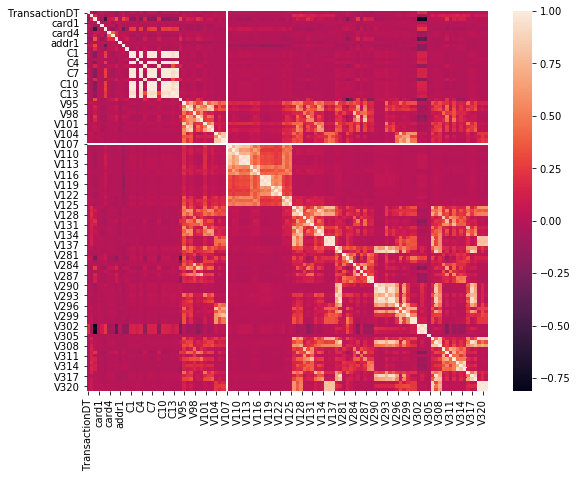

In [17]:
# correlation
col_balance=X_train.columns.tolist()
correlation=X_train.corr()
print(correlation)

plt.figure(figsize=(9, 7))
sns.heatmap(correlation)
plt.savefig("correlation.png")

In [27]:
# vif
def calulate_vif(X):  
    X[X.shape[1]]=1
    #vif
    vif=[]
    for i in range(X.shape[1]-1):
        vif.append(variance_inflation_factor(X.values,i))
    #result_out
    yy=pd.DataFrame(X.columns[:-1,])
    yy.rename(columns={0:"var_name"},inplace=True) 
    yy["vif"]=vif
    print(yy)


In [19]:
col_list=X_train.columns.tolist()
# print(col_list)
#calulate_vif(X_train_filter_fill[col_list])

['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']


In [36]:
calulate_vif(X_train[['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']])

c:\users\8\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


           var_name            vif
0     TransactionDT       1.091443
1    TransactionAmt       1.211365
2         ProductCD       5.593843
3             card1       1.023290
4             card2       1.043145
..              ...            ...
108            V317  895407.844654
109            V318  149847.475156
110            V319    7305.496028
111            V320  102013.615253
112            V321  100281.442635

[113 rows x 2 columns]


### Feature Selection: use Lasso to select useful features

[-1.35710812e-03  1.43358431e-03  5.19426183e-03 -2.92795080e-03
 -2.27739178e-03  2.08685142e-02  1.60523512e-03 -5.57064967e-04
 -8.47573826e-03 -9.24656306e-04 -8.37903758e-04 -2.64300250e-04
 -0.00000000e+00  5.96015088e-02 -2.39340240e-03  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.76218816e-02 -0.00000000e+00
  3.11202549e-03  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -4.50123984e-03 -3.52549497e-02 -2.22385666e-03 -0.00000000e+00
 -8.76293516e-03 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  7.48678478e-03 -0.00000000e+00  7.31564645e-03
 -3.98076761e-03 -6.14273632e-03 -0.00000000e+00  0.00000000e+00
  4.58547906e-03  2.94127950e-03 -4.75322258e-03 -0.00000000e+00
  5.97663362e-03  5.71814622e-03 -3.87613316e-03  3.59727426e-04
 -6.06538689e-04 -1.30987110e-03 -0.00000000e+00  0.00000000e+00
  3.10515274e-03 -1.55126668e-03  2.29493080e-03  9.60950844e-03
  0.00000000e+00  3.39796170e-03  0.00000000e+00  0.00000000e+00
 -1.82246967e-04  9.34362

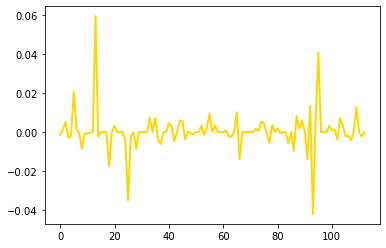

In [13]:
alpha = 0.0001
lasso = Lasso(alpha=alpha)
model = lasso.fit(X_train,y_train)
print(model.coef_)
plt.plot(model.coef_, color='gold', linewidth=2,label='Lasso coefficients')

In [14]:
coef=model.coef_
for i in range(0,len(model.coef_)):
    if model.coef_[i]!=0:
               coef[i]=1

In [15]:

y_train=pd.DataFrame(y_train,columns=["Y"])
y_test=pd.DataFrame(y_test,columns=["Y"])


coef_X_train=coef*X_train
data_train=X_train.join(y_train)


coef_X_test=coef*X_test
data_test=coef_X_test.join(y_test)


In [16]:
listdrop=[]
colname=data_train.columns.tolist()
coef=model.coef_
for i in range(0,len(model.coef_)):
    if model.coef_[i]==0:
            listdrop.append(colname[i])
            
len(listdrop)

36

In [34]:
data_train=data_train.drop(columns=listdrop)
# data_train.to_csv('train.csv')

data_test=data_test.drop(columns=listdrop)
#data_test.to_csv('test.csv')